# Machine Learning in Python - Project 2

Due Friday, April 15th by 5 pm UK local time.

by Mia WU(s2025818) & Huanyu Su(s2171849) & Zhongtian Zheng(s2139149) & Peiran Zhang(s2184444)

## 0. Setup

In [1]:
#(if need please install first, and please restart after install)
!pip install sidetable
!pip install dython 
!pip install treeinterpreter

Please install the packages of sidetable and dython first and if needed please restart runtime. And then import the packages below.

In [2]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier

# calculate tools

import sidetable as stb

# correlation package

import dython
from dython.nominal import associations

# Use the confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from treeinterpreter import treeinterpreter as ti

# warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', 32)

In [3]:
#import os
#from google.colab import drive

#drive.mount('/content/drive')
#os.chdir('drive/My Drive/Colab Notebooks/mlp/project2')
#!ls 

In [4]:
# Load data
d = pd.read_csv('hotel.csv')
df = d.copy()

## 1. Introduction
Online room booking, provides flexible reservation mechanisms and clear hotel policies for multi-channel sales, is a key element for highly efficient hotel operations, especially in the evolving OTA (Online Travel Agent) business environment. **However**, the high rate of cancellations has become a major problem for hotel operations. The hotel needs to reserve the rooms booked by the users and at the same time minimize the loss caused by the sudden withdrawal of the users. 

To balance user satisfaction and hotel revenue, we use data collected by [Antonio, Almeida and Nunes, 2019](https://www.sciencedirect.com/science/article/pii/S2352340918315191#f0010) on hotel bookings，which are real data came from two real hotels in Portugal, and numerous statistical models to analyze how cancellation affect hotel. After comparison, the most explanatory predict model with high accuracy was about to make a proposal to hotel operators to interpret why customers cancel their reservations and give some suggestions to deal with the inconsistency between user behavior and predictions.

The overall approach is as follows. **First**, we processed the original data for missing values, that based on listwise deletion and imputation methods, and outliers, and categorized the agent and country variables (see Part II for details). We **then** analyzed the effect of single and multiple variables on the cancel rate by descriptive statistics and removed those variables with little effect. **After that** we extract the influential variables and create a list of features of numerical and categorical variables to introduce into the model. 

To explore, we create six models, which are Random Forest Classifier, Extra Trees Classifier, Cat Boost, Decision Tree Classifie, ANN and Logistic Regression base on the data after processed. **And decided to use Random Forest Classifier**, which has the highest accuracy and reasonal explanation, to find the relationship among is_canceled and numerous factors.

In general, we have come to the following conclusions:

The accuracy of the model prediction is 87.86%, where country, deposit type, total of special requests, agent and lead_time have a greater impact on the prediction result. We found that:
- the more local (Portuguese) users, the higher the probability of cancellation.
- the deposit type of none refund have large probability of cancellation.
- the fewer requests for the order or the fewer changes to the order, the higher the possibility of cancellation.
- agent pays have large probability of cancellation
- the longer lead time, the higher the possibility of cancellation

In response to economic feasibility, we can suggest the following to hotels that:
- implementing a slightly stricter cancel policy for local users.
- A more flexible reminder and refund strategy for orders booked more than 200 days, such as sending an email to remind users one month before check-in to prevent losses to hotels caused by cancellations near the end of the period.

As for other conclusions, we think it is more difficult to change in the market environment, for example, even though agents pay higher cancellation rates, we cannot eliminate agents as a sales channel in order to get good revenue. But we use these recommendations to develop more flexible refund and change policies for different groups combined with the market environment.

## 2. Exploratory Data Analysis and Feature Engineering

In this part we include a detailed discussion and visualizations of data. 

To analyze the influence of cancellations more rationally, we pretreated the four variables with missing values.

Through analysis (see *def feature_process()* for details), we remove the country column with a missing rate of 94%, fill the missing values of children by using mode imputation, newly define the missing values of agents as the 'missing' category, and put the missing values of countries with the original category of 'others'. We also apply outliers to adr, adults, children, and babies (see *def feature_process()* for details) and add four new variables, which are younger, people, younger_rate and stay_days.

We then performed descriptive statistical analysis on the processed data and obtained that the more relevant variables are lead_time, country, market_segment and agent. In addition, by examining the distribution of the variables, we concluded that adr (the single price of hotel room per night) and arrival time (especially month) also have an effect on hotel cancel rate.

We complete this section in three steps, which are:

2.1 Data preprocessing

2.2 Data analysis and visualizations

2.3 Create feature engineering

### 2.1 Data preprocessing


We first look at the statistical summary for all numeric variables in order to find if there is any abnormal signs. For example, the maximum value of adults is 55, which is impossible. Also, the minimum value of adr is negative, which is also not realistic.

In [5]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


Then we look at the information of all variables. We can see that some variables have missing values. So we create a table to display the proportion of missing data for each column.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

The following table display all columns containing missing values and their proportion.

In [7]:
# checking for null values 
null = pd.DataFrame({'Null Values' : df.isna().sum(), 'Percentage Null Values' : (df.isna().sum()) / (df.shape[0]) * (100)})
null.loc[null['Percentage Null Values'] > 0]

,Null Values,Percentage Null Values
children,4,0.003350
country,488,0.408744
agent,16340,13.686238
company,112593,94.306893


Here we define a function called feature_process, which implements the pre-process for the data. 

As shown above, there are 4 variables having missing values: children, country, agent and company. Note that the proportion of missing values in company is up to 94%, so this variable does not provide enough information and we have to dorp it. As for children, missing values consist of only 0.3% of the dataset, which makes it reasonable to impute them with its mode, i.e. 0.

For the country variable, we set the missing values as a new category called 'missing'. Then we create different categories. Specifically, we set Portugal as 'Local', other countries excluding France, UK, Spain and Germany as others. 

The agent column contains 13.7% missing values, and itself is a categorical variable in its nature. Therefore, we define a new level called "missing", and impute the missing values with it. Besides, we convert the agent variable into category and adjust their names so that they are more meaningful. After that, we set all IDs whose occurrence times are less than 3000 as 'others', in order to make the correlation coefficient calculation more reasonable.

The variables related to time also need to be processed. To be more specific, we
create four new columns for further calculation, namely arrival_month, arrival_date, arrival_day and Weekday.

We also make some changes to the meal variable. According to the description of original dataset, the 'Undefined' type should be the same as 'SC' type, so we just replace the former with the latter.

At the end of this function, we deal with abnormal values. For example, average daily rates cannot be a negative value or zero, and the number of guests in a single room cannot be too large or too small. For further analysis, we also create some new variables such as 'younger_rate' which is the proportion of children and babies in a group of guests.

In [8]:
def feature_process(X):
  X_ = X.copy()
  ### Process children missing values
  X_.children.fillna(X_.children.mode()[0], inplace=True)

  X_.insert(df.shape[1],'company_missing',0)
  X_.loc[pd.isnull(df.company),'company_missing'] = 'missing'
  X_.loc[~pd.isnull(df.company),'company_missing'] = 'exiting'

  ### Process agent variable
  # First, we fill the NAs with zero
  X_.loc[pd.isnull(X_.agent),'agent'] = 0 
  # Then we turn the agent variable into integers
  X_['agent'] = X_['agent'].apply(np.int64)
  # Add "ID" to the names
  X_['agent'] = ['ID_%i'%i for i in X_['agent']]
  # Change the name of missing values
  X_.loc[X_.agent == 'ID_0','agent'] = 'missing'
  # We set all IDs with less than 3000 occurrences to others
  # to make the calculation of the number of relations more reasonable
  id_indx = X_.agent.value_counts()[X_.agent.value_counts()>5000].index 
  X_.agent = X_['agent'].apply(lambda x: x if x in  id_indx else 'others')

  ### Process country
  # Define a functioin assign each country into different categories
  def group_country(row):
    # For Portugal we set it as local 
    if (row['country'] == 'PRT'):
        return 'Local'
    # For UK, France, Spain and Germany, we save the original name
    elif  (row['country'] in ['GBR','FRA','ESP','DEU']):
        return row['country']
    # For other countries we just set them as others
    else:
        return('Others')    
  X_['country'] = X_.apply(group_country, axis = 1)


  ### Process time variables
  #Modify the English month of arrival_date_month to Chinese month
  import calendar
  month = []
  for i in X_.arrival_date_month:
    mon = list(calendar.month_name).index(i)
    month.append(mon)
  X_.insert(4,"arrival_month",month)
  #Merge the month, year and date variables into a new variable arrival_date
  #Add a column for the month, day and year of the reservation arrival arrivals arrival_date
  #Add whether it is weekends or weekday
  X_[["arrival_date_year","arrival_month","arrival_date_day_of_month"]] = X_[["arrival_date_year","arrival_month","arrival_date_day_of_month"]].apply(lambda x:x.astype(str))
  date = X_.arrival_date_year.str.cat([X_.arrival_month,X_.arrival_date_day_of_month],".")
  X_.insert(3,"arrival_date",date)
  X_["arrival_date"] = pd.to_datetime(date)
  X_["arrival_day"] = X_.arrival_date.dt.weekday
  X_["Weekday"] = X_.arrival_day.apply(lambda x: "Weekday" if x in [0,1,2,3,4] else "Weekends") 
  X_.arrival_month = X_.arrival_month.astype("int")

  ### Process meal
  # According to the original dataset introduction, 
  # the Undefined / SC - No meal package in the dining field is a category
  X_.meal.replace("Undefined", "SC", inplace=True)

  ### Process abnormal values
  # adr is the average daily rate, 
  # its minimum value is shown as -6.38 and the maximum value is 5400, 
  # and the data that shows adr as a non-positive number will be deleted.
  X_.drop(X_[X_['adr']<=0].index, inplace=True)
  # Some rooms with more than 10 adults, or with 10 children or infants, 
  # should also be excluded
  X_.drop(X_[X_['adults']>=10].index, inplace=True)
  X_.drop(X_[X_['children']>=10].index, inplace=True)
  X_.drop(X_[X_['babies']>=10].index, inplace=True)
  # adults, babies and children cant be zero at same time, so dropping the rows having all these zero at same time
  zero_people = (X_['children'] == 0) & (X_['adults'] == 0) & (X_['babies'] == 0)
  X_[~zero_people]
  # add new columns
  X_['younger'] = X_['babies']+X_['children']
  X_['people'] = X_['children']+X_['babies']+X_['adults']
  X_['younger_rate'] = X_['younger'] / X_['people']
  X_.younger_rate.loc[X_.younger_rate.isna()] = 0
  X_['stay_days'] = X_['stays_in_weekend_nights']+X_['stays_in_week_nights']

  return X_

In [9]:
# create preprocessed dataframe df
df = feature_process(df)

In [10]:
# Split numeric features and categorical features
num_feature = ["lead_time","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","is_repeated_guest",
               "previous_cancellations","previous_bookings_not_canceled","booking_changes","days_in_waiting_list","adr",
               "required_car_parking_spaces","total_of_special_requests"]
cat_feature = ["hotel","meal","country","market_segment","reserved_room_type","assigned_room_type",
               "deposit_type","agent","customer_type"]

We use a function [associations](http://shakedzy.xyz/dython/modules/nominal/) from `dython` package, it can calculate the correlation of features. For the categorical variables, we apply [Theil's U](https://en.wikipedia.org/wiki/Uncertainty_coefficient)  (i.e., uncertainty coefficient) is a measure of nomial association. 
Suppose we have two random variables X, Y. By joint distribution probabilities，conditional probabilities and calculating the various entropies, we can determine the degree of association between the two variables.
The entropy of a single distribution is given as:
$$H(X)=-\sum \limits_{x} P_X(x) \log P_X(x)$$
Then the conditional entropy is given as:
$$H(X|Y)=-\sum \limits_{x,y}P_{X,Y}(x,y) \log P_{X|Y}(x|y)$$
Hence the uncentainty coefficient or proficiency is defined as:
$$U(X|Y)=\frac{H(x)-H(X|Y)}{H(X)}=\frac{I(X;Y)}{H(X)}$$
*where $I(X;Y)$ is a normalized mutual information*
The [Theil's U](https://en.wikipedia.org/wiki/Uncertainty_coefficient) is very useful for measuring the validity of a statistical classification algorithm, Here we use it to calculate correlation coefficients for categorical variables that will be very effective.

The graph below shows a heat map of the correlation coefficients for the categorical variables, from which we can see that the variables that have a greater impact on booking cancellations are `country`, `market_segment`, `deposit_type` and `agent`. Of these, deposit represents whether the customer pays a deposit or not, which is obviously related to the cancellation rate. Therefore, in the exploratory analysis that follows, we will examine the impact of these variables.

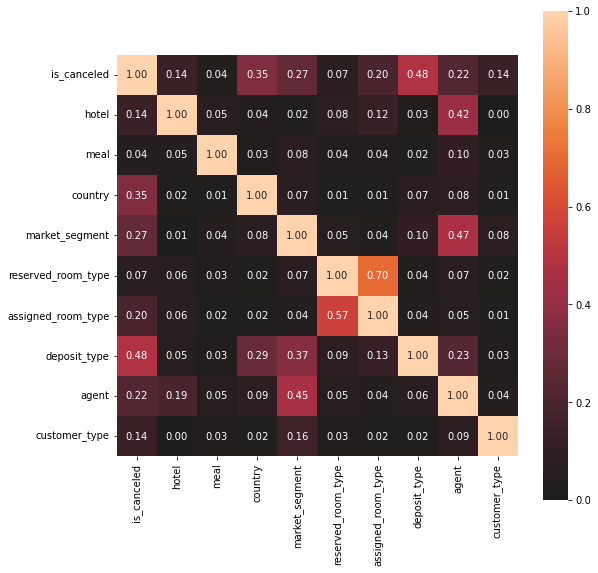

In [11]:
associations(df[['is_canceled']+cat_feature],figsize=(9,9),nom_nom_assoc='theil')
plt.show()

Next for numerical variables we study the relationship graphs, we will choose the `Spearman` method as it studies monotonic relationships between variables, whereas the `Pearson` method studies linear relationships. In this dataset we are more concerned with the monotonicity of the association between the variables rather than necessarily requiring the existence of a linear association.

As we can see there is a strong influence of `lead_time` and `previous_cancellations`, it is reasonable to assume that customers who have previously cancelled will be more likely to cancel their orders, so we will focus on the influence of `lead_time` in the rest of the analysis.\
In addition, we should treat two features that are highly correlated when modelling (e.g. only one of them is selected to enter the model) to reduce effects such as multicollinearity.

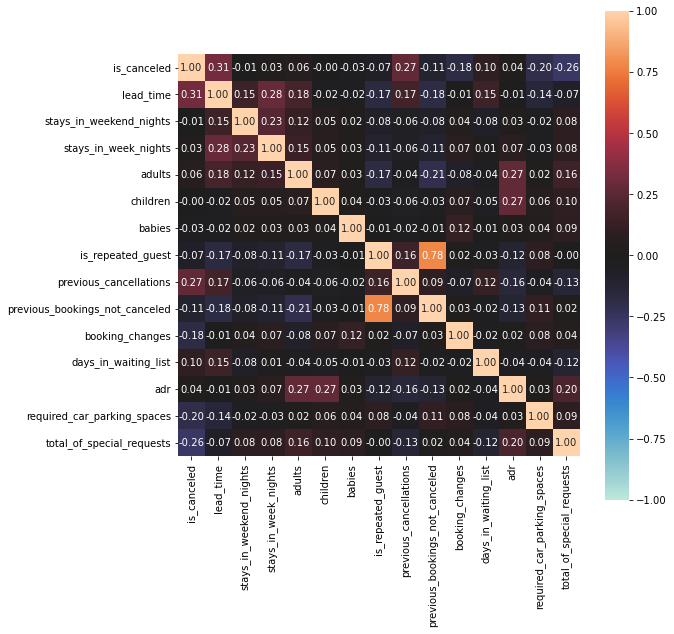

In [12]:
associations(df[['is_canceled']+num_feature],figsize=(9,9),num_num_assoc='spearman')
plt.show()

### 2.2 Data analysis and visualizations

There are two types of hotels in the original data, Resort hotel and City hotel, which may target different customer groups. In order to verify this idea, we use pie charts to show the cancellation rate of the two types of hotels, we can see that the cancellation rate of city hotel is 42.21%, which is almost half of the reservation. Resort hotel's cancellation rate is 28.08%, which is lower than the cancellation rate of city hotel. In summary, the two hotels need to be analyzed separately, so the hotel variable will be kept subsequently.

(39307, 39) (78121, 39)


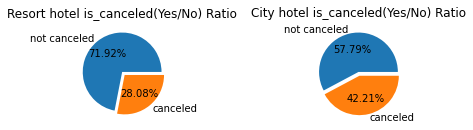

In [13]:
# Enter the data analysis phase
# First we will compare the two hotels to see if there is a difference
d_Resort = df.loc[df['hotel']== 'Resort Hotel']
d_City = df.loc[df['hotel']== 'City Hotel']
print(d_Resort.shape,d_City.shape)

d_Resort['is_canceled_label'] = list(map(lambda x: 'not canceled' if x == 0 else 'canceled' , d_Resort['is_canceled']))
d_City['is_canceled_label'] = list(map(lambda x: 'not canceled' if x == 0 else 'canceled' , d_City['is_canceled']))


plt.subplot(1,3,1)
plt.pie(d_Resort['is_canceled_label'].value_counts(),labels=d_Resort['is_canceled_label'].value_counts().index,autopct='%1.2f%%',explode=(0,0.1)) #每一块饼图距离中心的距离，默认值(0,0)就是不离开中心，explode = (0,0,0.1,0) 表示将第三块分离出来，而这里就表示将第一块分离出来
plt.title('Resort hotel is_canceled(Yes/No) Ratio')
plt.subplot(1,3,3)
plt.pie(d_City['is_canceled_label'].value_counts(),labels=d_City['is_canceled_label'].value_counts().index,autopct='%1.2f%%',explode=(0,0.1)) #每一块饼图距离中心的距离，默认值(0,0)就是不离开中心，explode = (0,0,0.1,0) 表示将第三块分离出来，而这里就表示将第一块分离出来
plt.title('City hotel is_canceled(Yes/No) Ratio')
plt.show()

Then we study the relationship between the arrival date (year) and the lead time of the reservation cancellation status. We show the distribution of the data through a violin plot. From the plot we can see that under different years, for cancelled bookings, the mean and interquartile range are similar for all years, but the shape of the distribution is different. We can obtain that the year of arrival has little effect on booking cancellations, and the variable year will be removed subsequently.

<AxesSubplot:xlabel='arrival_date_year', ylabel='lead_time'>

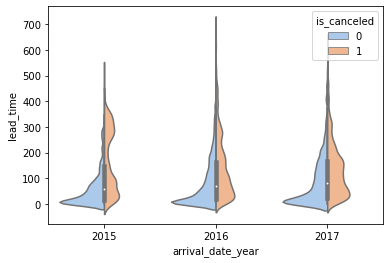

In [14]:
# violin plot
sns.violinplot(x="arrival_date_year", y="lead_time", hue="is_canceled",
                    data=df, palette="pastel", split=True)

From the histogram below we can see that the highest frequency of adr is where adr is around 60 - 70.

<AxesSubplot:xlabel='adr', ylabel='Count'>

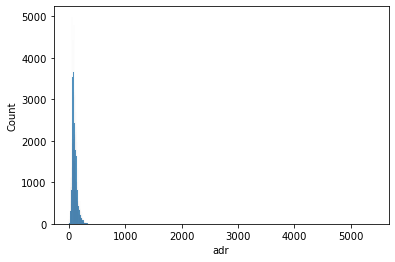

In [15]:
sns.histplot(df, x="adr")


We now consider the effect of room unit price (adr) and month of arrival on the cancel rate. We use histogram to show the relationship between month and adr, and get the conclusion that the unit price of rooms in city hotels varies very little from month to month, while the unit price of rooms in resort hotels increases in the summer months, i.e. June, July and August, especially in August. The relationship between month and cancellation rate is shown by a line graph, which shows that the cancellation rate is higher in the month of high unit price for both city hotels and resorts, but the change is not significant in the plot. After discussion, we decided to keep month variable. The effect of influence will be discussed later in the model results.

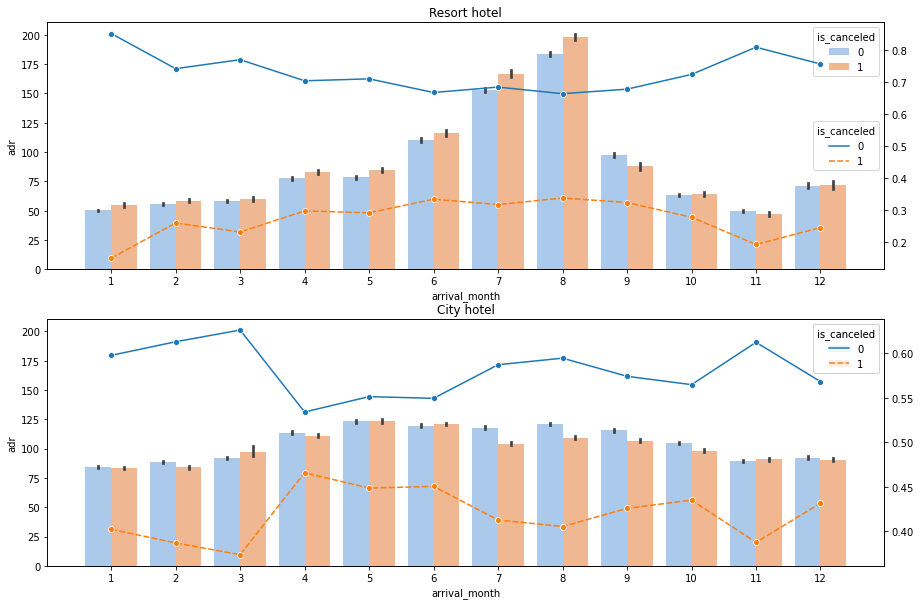

In [16]:
d_Resort['arrival_month_plot'] = d_Resort['arrival_month'].astype(int)
month=d_Resort[['arrival_month_plot','is_canceled']]
df_month=month.sort_values(by='arrival_month_plot', ascending=True)

d_City['arrival_month_plot'] = d_City['arrival_month'].astype(int)
month_c=d_City[['arrival_month_plot','is_canceled']]
df_month_c=month_c.sort_values(by='arrival_month_plot', ascending=True)

month_cancellation = pd.crosstab(df_month['arrival_month_plot'], df_month['is_canceled'], normalize = 'index')
month_cancellation.index = [0,1,2,3,4,5,6,7,8,9,10,11]

month_cancellation_c = pd.crosstab(df_month_c['arrival_month_plot'], df_month_c['is_canceled'], normalize = 'index')
month_cancellation_c.index = [0,1,2,3,4,5,6,7,8,9,10,11]

# use twinx() method along with seaborn to create a seperate y-axis, 
# one for the lineplot and the other for the barplot. 

f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize = (15, 10))

sns.barplot(x="arrival_month", y="adr", hue="is_canceled", data=d_Resort, ax=ax1,
            palette="pastel")
ax1_2 = ax1.twinx()

sns.lineplot(data = month_cancellation, marker='o')
plt.title('Resort hotel')

sns.barplot(x="arrival_month", y="adr", hue="is_canceled", data=d_City, ax=ax2,
            palette="pastel")
ax2_2 = ax2.twinx()

sns.lineplot(data = month_cancellation_c, marker='o')
plt.title('City hotel')

plt.show()

Let's examine the relationship between the percentage of cancellations and the `market_segment`. Some of these types have a very small percentage of data, so for the purpose of this analysis, we have changed the types with less than 5% of data to other categories. In the same way, we divided the data into resort hotel and city hotel, and drew the following histplot, from which we can see that in both types of hotels, online TA has the highest proportion, and the proportion of cancellations is greater than that of non-cancellations. However, in the group category, more customers in the resort hotel did not cancel their orders while more customers in the city hotel cancelled their orders, indicating that the type of hotel has an impact on the cancellation rate of the market segment as well.

In [17]:
id_indx = d_Resort.market_segment.value_counts()[d_Resort.market_segment.value_counts()>5000].index 
d_Resort.market_segment = d_Resort['market_segment'].apply(lambda x: x if x in  id_indx else 'others')
id_indx = d_City.market_segment.value_counts()[d_City.market_segment.value_counts()>5000].index 
d_City.market_segment = d_City['market_segment'].apply(lambda x: x if x in  id_indx else 'others')

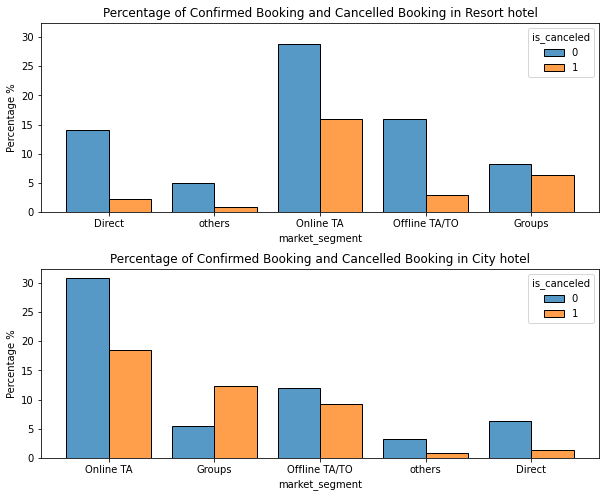

In [18]:
fig, ax = plt.subplots(2, 1, sharey=True,figsize = (10, 8))

sns.histplot(data=d_Resort,x='market_segment',hue='is_canceled',stat='percent',ax=ax[0],multiple='dodge',shrink=0.8)
sns.histplot(data=d_City,x='market_segment',hue='is_canceled',stat='percent',ax=ax[1],multiple='dodge',shrink=0.8)
ax[0].set_ylabel('Percentage %')
ax[1].set_ylabel('Percentage %')
ax[0].set_title('Percentage of Confirmed Booking and Cancelled Booking in Resort hotel')
ax[1].set_title('Percentage of Confirmed Booking and Cancelled Booking in City hotel')

fig.subplots_adjust(hspace=0.3)
plt.show()

Similar to the above, we also combine all the types less than 5% in the `distribution_channel` into others and draw a histplot, again TA/TO has the highest rate and more customers confirm their orders.

In [19]:
# There more than 1e6 cases, hence we convert the the type less than 5e3 times to 'others'.
id_indx = d_Resort.distribution_channel.value_counts()[d_Resort.distribution_channel.value_counts()>5000].index 
d_Resort.distribution_channel = d_Resort['distribution_channel'].apply(lambda x: x if x in  id_indx else 'others')
id_indx = d_City.distribution_channel.value_counts()[d_City.distribution_channel.value_counts()>5000].index 
d_City.distribution_channel = d_City['distribution_channel'].apply(lambda x: x if x in  id_indx else 'others')

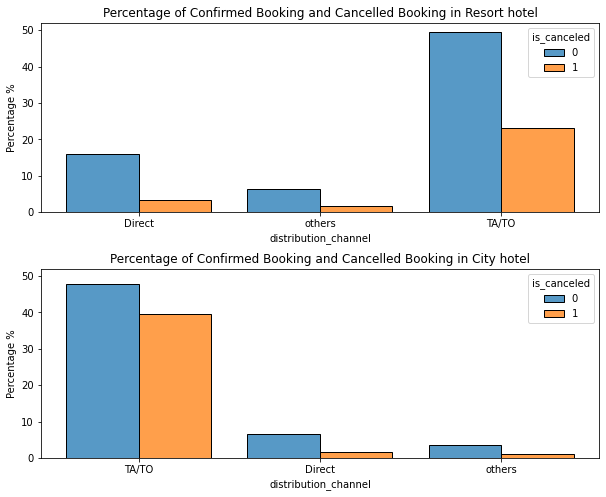

In [20]:
fig, ax = plt.subplots(2, 1, sharey=True,figsize = (10,8))

sns.histplot(data=d_Resort,x='distribution_channel',hue='is_canceled',stat='percent',ax=ax[0],multiple='dodge',shrink=0.8)
sns.histplot(data=d_City,x='distribution_channel',hue='is_canceled',stat='percent',ax=ax[1],multiple='dodge',shrink=0.8)
ax[0].set_ylabel('Percentage %')
ax[1].set_ylabel('Percentage %')
ax[0].set_title('Percentage of Confirmed Booking and Cancelled Booking in Resort hotel')
ax[1].set_title('Percentage of Confirmed Booking and Cancelled Booking in City hotel')

fig.subplots_adjust(hspace=0.3)
plt.show()

According to the distribution of the data, the overall pattern is that as the "length of advance booking" increases, the "number of cancellations" also increases, and the two show a positive correlation. The earlier the reservation is made, the more likely it is to be cancelled. Therefore, we keep the lead_time variable in the model.

Text(0, 0.5, 'cancel rate (%)')

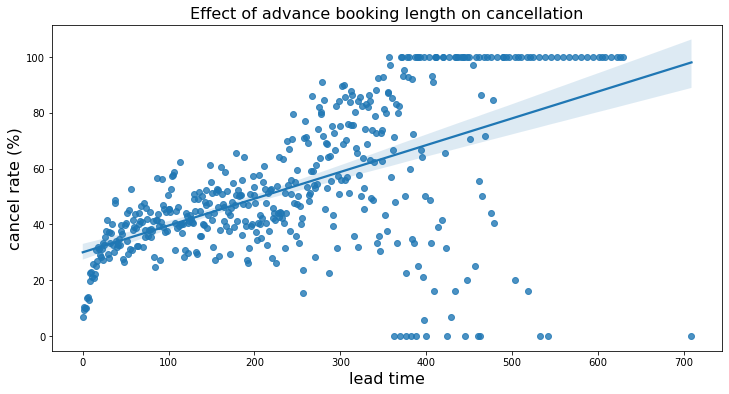

In [21]:
# Data for lead_time
lead_data = df.groupby("lead_time")["is_canceled"].describe().sort_values(by="mean",ascending=False)
x = lead_data.index

# Corresponding to the number of cancellations 
# (within 100 in proportion to the inductive value)
y = round(lead_data["mean"],4)*100

plt.figure(figsize=(12,6))
sns.regplot(x=x,y=y)
plt.title("Effect of advance booking length on cancellation",fontsize=16)
plt.xlabel("lead time",fontsize=16)
plt.ylabel("cancel rate (%)",fontsize=16)

By calculating the cancellation rates by country we find that Portugal has the highest local cancellation rate, followed by the UK, France, Spain and Germany.

In [22]:
df.stb.freq(['country'], cum_cols = False)

,country,count,percent
0,Local,47038,40.056886
1,Others,32240,27.455121
2,GBR,12055,10.265865
3,FRA,10360,8.822427
4,ESP,8489,7.229111
5,DEU,7246,6.170590


Below we plot two pie charts for distribution channels and market segments respectively. For market segments, we can see that online travel agents (TA), offline travel agents/travel operators and groups are the top three segments, consisting of over 80% of all orders. Similarly, travel agents and travel operators are the most important distribution channels, with themselves make up over 80% of all the channels.

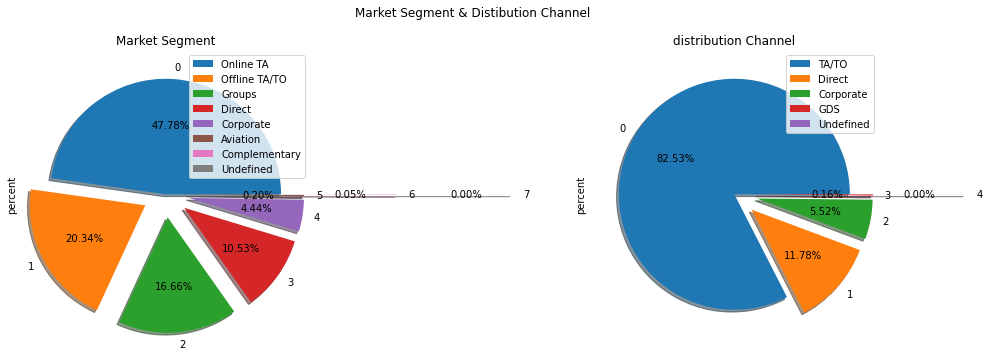

In [23]:
# Calculate the percentage of each category of distribution channels and market segments
distribution_channel = df.stb.freq(['distribution_channel'], cum_cols = False)
market_segment = df.stb.freq(['market_segment'], cum_cols = False)

plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
market_segment['percent'].plot.pie(explode = [0, 0.2, 0.2, 0.2, 0.2, 0.2, 1, 2], 
                        autopct = '%1.2f%%',
                        shadow = True
                 )
plt.legend(market_segment['market_segment'])
plt.title('Market Segment')

plt.subplot(1,2,2)
distribution_channel['percent'].plot.pie(explode = [0, 0.2, 0.2, 0.2, 1], 
                    autopct = '%1.2f%%',
                    shadow = True
                    )
plt.legend(distribution_channel['distribution_channel'])
plt.title('distribution Channel')

plt.suptitle('Market Segment & Distibution Channel')
plt.tight_layout()
plt.show()

Below is the graph of Percentage of Confirmed Booking and Cancelled Booking per Lead Time Month. It is obvious that orders that have lead time more than 7 months are more likely to be canceled than to be confirmed. Generally, the longer the lead time, the higher the probabilities the orders to be cancelled compared to be confirmed.

In [24]:
import plotly.graph_objects as go
lead_time_months = df['lead_time'] // 30
lead_time_months.value_counts() / len(df)
df['lead_time_month'] = df['lead_time'] // 30

lead_time_canceled =  pd.crosstab(df['lead_time_month'], df['is_canceled'], normalize = 'index')
lead_time_canceled_deposit = pd.crosstab(df['lead_time_month'], df['deposit_type'], normalize = 'index')

fig = go.Figure(data=[
    go.Bar(name='Confirmed Booking', x=lead_time_canceled.index, y=lead_time_canceled[0]),
    go.Bar(name='Cancelled Booking', x=lead_time_canceled.index, y=lead_time_canceled[1])
])
# Change the bar mode
fig.update_layout(barmode='group', title = 'Percentage of Confirmed Booking and Cancelled Booking per Lead Time Month',
                 yaxis=dict(
                 title='Percentage',
                 titlefont_size=16,
                 tickfont_size=14,)
                ,xaxis=dict(
                 title='Lead Time Month',
                 titlefont_size=16,
                 tickfont_size=14,))
fig.show()


### 2.3  Create feature engineering

From the previous exploratory data analysis, we selected the required features and, to facilitate the fitting of the model (e.g. for categorical variables, we need to process them with OneHot), we therefore divided the features into numerical and categorical features and extracted them.

In [139]:
num_feature = ["lead_time","arrival_month",
              "people","younger","is_repeated_guest",
               "previous_cancellations",
               "booking_changes","days_in_waiting_list","adr",
               "required_car_parking_spaces","total_of_special_requests","stay_days"]
cat_feature = ["hotel","meal",
                "country","market_segment",
                "reserved_room_type","assigned_room_type","deposit_type",
                "agent","company_missing","customer_type","Weekday"]
# Redefined based on descriptive row statistics
feature = num_feature + cat_feature

   
X = df[feature]
y = df.is_canceled
# Split train dataset and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

In [140]:
for feature_ in num_feature:
    if feature_ not in X.select_dtypes("number").columns:
        print(feature_)
# Every thing should be there!!!!

In [141]:
# Check !!! IF every feature is mentioned
for feature_ in X.columns:
    if feature_ not in feature:
        print(feature_)


## 3. Model Fitting and Tuning

### Random Forest Algorithm Introduciton & Interpretation
Before, we would like to explain why we choose tree based model. As we have observed in the previous heatmap, the correlations is too big to ignore. The tree structure takes account of the correlation naturally. In addition, the tree based model is invariant to different scaling for the numerical features. The experiment on various model meets our early assumption that a pruned decision tree (*with about 84% correct classification rate*) performs better than logistic regreeesion. Although the result is, we want to improve on the basic single tree by introducing ensembling learning technique, which corrects the overfitting of a single decision tree. 

The increase of accuracy comes at the cost of interpretability since it involves multiple trees, but the random forest is not an absolute 'black box'. We are going to crack it using three methods: [Permutation Feature Importance (PFI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py) considering the correlations, [Feature Importance based on Mean decrease in Impurity](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) (MDI feature importance) and [Feature Contribution Calculation](https://blog.datadive.net/interpreting-random-forests/) by prediction decomposition.

Before implementing the random forest algorithm, we want to have a brief review of how the decision tree classification works. Later on, we will give our explanation why a groups of tree can perform better. In the very beginning, all the training data forms a root where the impurity is high (samples of cancelled and confirmed bookings are mixed). The algorithm tries to make a split based on the value of a certain feature (if the value of a feature smaller than the threshold) and divides the parent node into two child nodes (nodes is just the subgroup of data).

After a series of split, the tree would grow until the termination conditions are met, such as the samples in the node is less than a certain amount, or the maximum depth exceeds our limiation. Finally, a tree woul have many terminal nodes (leaf), with each leaf having similar observations and is assigned a predicted class (choose the class with more number of samples to be that node’s predicted class).   

For each node *T*, there are two common measures for impurity (simplified for two-class problem):
 $$ Gini\space Impurity = 1 - \sum_{j=1}^2 P(j|T)$$
 $$ Entropy\space Impurity = - \sum_{j=1}^2P(j|t)log_2P(j|T)$$
We can see that when a node is pure - totally of one class, $P(j|T) = 1$, the impurity equals to zero.

As we know, a tree may overfit the data too well and has poor generability, which generally tackled by pre-pruning (limit the maximum depth, minimum samples in a leaf) and post-pruning (penalize the size of a tree). A tree can still underperform when the unseen data is sort of different from training data. For example, while it is the feature A that split the training data best and feature B has smaller proportion in the training data, it could whole the other situation in the unseen data. In addition, the most important feature A, giving the first split, may have many missing values in the unseen data, then the whole model would be meaning less. 

Random forest algorithm can well overcome these pontential problems. As its name implies, it is random in two sense - 
* Random sampling of training data points when building trees
* Random subsets of features considered when splitting nodes  

These randomness help to produce different kinds of trees forming a **forest**, so the features having smaller importances in one tree, may have larger importances in another. Speaking in a statistical perspective, random forest algorithm reduces the variances of the trees with slight increase of bias. More illustration can be seen on [Wikipedia](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). The prediction for a single observation will be made by taking the majority votes in the case of classification trees. 

In [142]:
rf_parameters = {
 'randomforestclassifier__max_depth': [20, 30, 40, 50],
 'randomforestclassifier__max_features': ['sqrt','log2'],
 'randomforestclassifier__min_samples_leaf': [2,5,10],
 'randomforestclassifier__n_estimators': [100,200,250,300]}
one_hot = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(transformers=
                            [('One hot',one_hot, cat_feature)],
                            remainder='passthrough') 
rf_model = RandomForestClassifier()

In [143]:
pipe = Pipeline(
    [("preprocess",preprocessor),
    ("classifier",rf_model),
    ])


In [144]:
# Set random_state seems to be much slower, 
# CPU recourse is not fully engaged.
""" random_cv = RandomizedSearchCV(pipe,
                           rf_parameters,
                           cv = 5,
                           n_jobs = 5,
                           verbose = 2)

random_cv.fit(X_train, y_train) """

' random_cv = RandomizedSearchCV(pipe,\n                           rf_parameters,\n                           cv = 5,\n                           n_jobs = 5,\n                           verbose = 2)\n\nrandom_cv.fit(X_train, y_train) '

In [145]:
""" rf_best = random_cv.best_estimator_
rf_best.get_params """

' rf_best = random_cv.best_estimator_\nrf_best.get_params '

We store the optimal values of the parameters and fit a new pipeline.

In [146]:
best_pipe = Pipeline(                                       
    [("preprocess",preprocessor),
    ("classifier",RandomForestClassifier(max_depth=40, max_features='sqrt',
                                        min_samples_leaf=5,
                                        n_estimators=200,
                                        random_state=42))])   
best_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hotel', 'meal', 'country',
                                                   'market_segment',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'deposit_type', 'agent',
                                                   'company_missing',
                                                   'customer_type',
                                                   'Weekday'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=40, max_features='sqrt',
                                        min_samples_leaf=5, n_estimators=200,

Below is the visulization of confusion matrix of our model. It looks like that the accuaracy for true label of 0 is much higher than that for true label of 1.

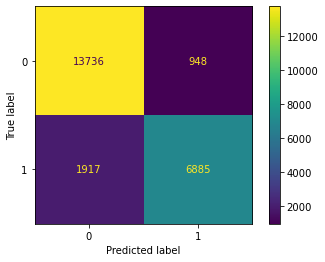

In [147]:
predictions = best_pipe.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=best_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_pipe.classes_)
disp.plot()

plt.show()

We also print the classification report. We can see that the true positive rate for true value of 1 is less than that for true value of 0. The accuracy is 87.86%.

In [148]:
from sklearn.metrics import classification_report
y_pred = predictions
print(classification_report(y_test, y_pred))
print("The accuracy is", round(sum(y_pred==y_test) / len(y_pred), 5))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     14684
           1       0.88      0.78      0.83      8802

    accuracy                           0.88     23486
   macro avg       0.88      0.86      0.87     23486
weighted avg       0.88      0.88      0.88     23486

The accuracy is 0.878


Next, we will use several methods to investigate the ranking of the importance of features in a random forest. The first is [Mean Decrease in Impurity (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py): it represents the average reduction in error for each feature. As we know, a decision tree splits a node into two sub-nodes according to some rules. Each split is for a feature that minimises the error. We summarise all the cases on all trees where this particular variable gets a split that minimises the error. In the sk-learn package, the boosting effect from each split is obtained by weighting the number of samples reaching the node and then normalising the importance of the features. 
However, the feature importance calculated by this method suffers from two drawbacks:

* MDI is calculated from the training data and may not reflect its feature importance on the test set.

* The MDI method prefers high-basis features, i.e. features with many unique values.

Based on the drawbacks of MDI, we have dealt with categorical variables that have extremely many categories in our previous analysis for the sake of accuracy (e.g. agent, which we grouped into 5 categories).In the figure below, we can see that categorical variables such as country, deposit_type, etc. have a higher importance, and the final importance plot shows the results after onehot, so that the importance is calculated separately for each sub-category of the categorical variable. To compare the reliability of the validation methods, we next try the Permutation Importance method.

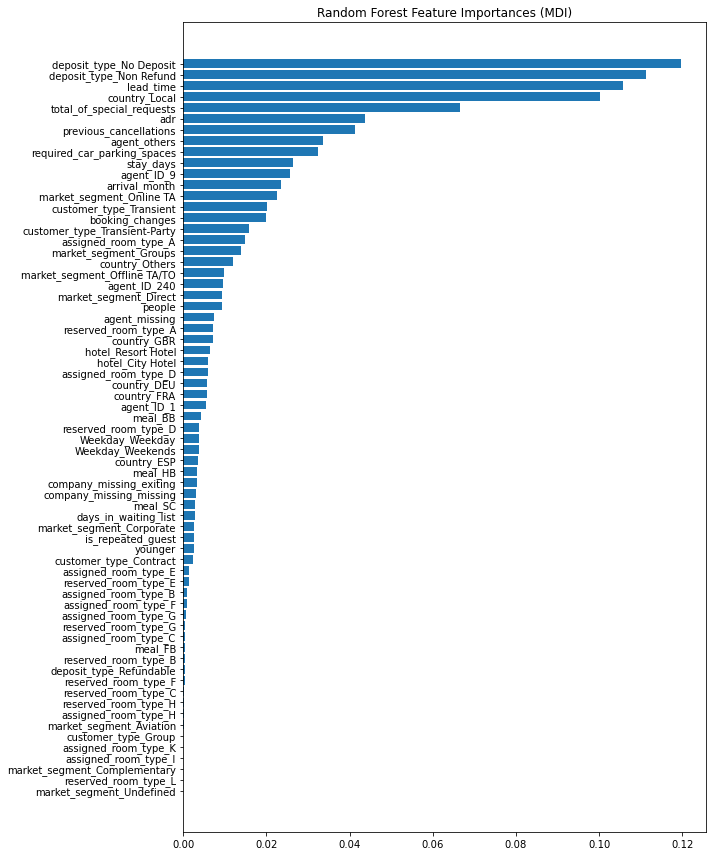

In [149]:
# Extract the transformed named transformers "One hot" in the named step "preprocess"
ohe = best_pipe.named_steps['preprocess'].named_transformers_["One hot"]
feature_names = ohe.get_feature_names_out(cat_feature)
feature_names = np.r_[feature_names, num_feature].tolist() # IF I turn it to list here, then it can not be indexed by np array...


tree_feature_importances = best_pipe.named_steps["classifier"].feature_importances_
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10,12))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.array(feature_names)[sorted_idx])               
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

[Permutation Feature Importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py)
The main idea of Permutation Importance is that by holding other features constant and taking N samples of a feature and randomly disrupting them, the drop in the model score indicates how much the model depends on that feature.

The advantage of Permutation Importance is that it ensures that the distribution of feature substitutions is approximate to that of the original feature, and can be computed several times using different permutation methods. However, if the model has multicollinearity or the variables are highly correlated, the PI cannot derive the significance of the features and clustering, dimensionality reduction or correlation of the variables is required. As we did when selecting the features, we removed some variables from the set of highly correlated variables leaving one.

In [150]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    best_pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs = 5
)

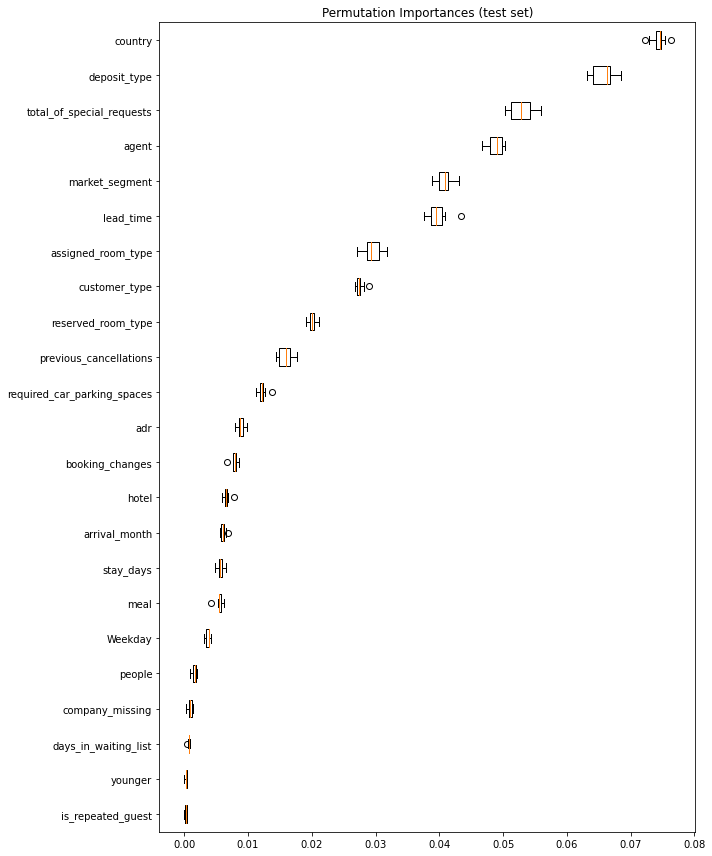

In [151]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (10,12))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Random Forest interpretation in terms of [decision path](https://blog.datadive.net/interpreting-random-forests/)  
Firstly, we can consider a single tree, in which every prediction follows a decision path that consists of a sequence of split. The differences of the probability we predict a class j - $P(j|t)$ of two nodes could be regarded as the contribution of the feature deciding the split. In this perspective, the prediction function that a certain observation $x$ belongs to j class, can be written as $$P(j|x) = P(j|Root) + \sum_{k=1}^K contribution$$ where $K$ is the number of features, $P(j|Root)$ is the probability that one observation at the root of the node belongs to class $j$ and contrib(x,k) is the contribution from the k-th feature in the feature vector x. This is similar to the expression of a linear regression (a + bx). As the forests is just bunch of trees, we just need to accumulate the contributions in all the trees.
"As the random forest is simply bunches of trees, we can accumulate the contributions of features in different trees. The formulation will be $$P(j|Forest) = \frac{1}{N}\sum_{n=1}^N P(j|t_{n}) + \sum_{k=1}^K (\frac{1}{N}\sum_{n=1}^N contribution(x,k))$$, Calculation of the contributions will use the module [treeinterpreter](https://github.com/andosa/treeinterpreter).

In [152]:
prediction, bias, contribution = ti.predict(best_pipe[-1],best_pipe[:-1].transform(X_train))

In [153]:
X_train_array = best_pipe[:-1].transform(X_train)

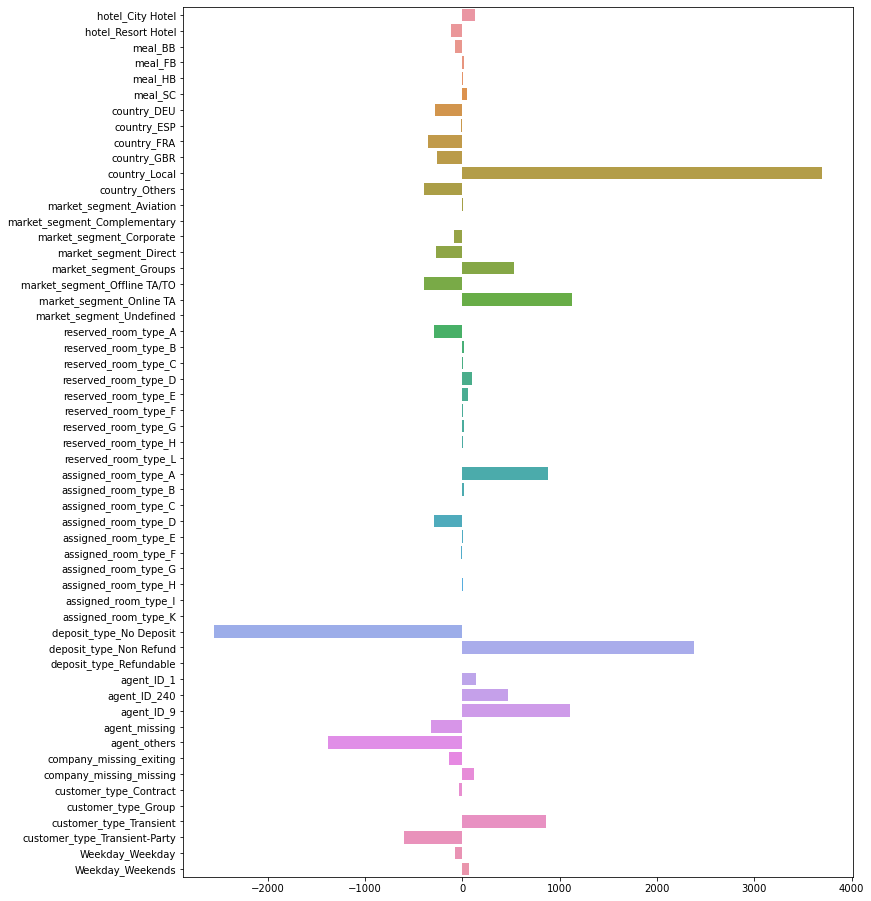

In [154]:
plt.figure(figsize=(12,16))
sns.barplot(np.sum(np.multiply(X_train_array[:,0:55]!=0, contribution[:,0:55,1]),axis = 0),feature_names[0:55])
plt.show()

In [155]:
np.sum(np.multiply(X_train_array[:,0:55]!=0, contribution[:,0:55,1]),axis = 0)

array([ 1.24585412e+02, -1.18765200e+02, -7.69847488e+01,  1.36996130e+01,
        1.76838115e+00,  5.13911703e+01, -2.81182887e+02, -9.58339823e+00,
       -3.53018490e+02, -2.64655163e+02,  3.69714717e+03, -3.96672295e+02,
        4.64610129e+00, -5.28898289e-02, -8.22395323e+01, -2.76158154e+02,
        5.31194333e+02, -3.92600138e+02,  1.12736658e+03,  0.00000000e+00,
       -2.94155700e+02,  1.55981063e+01,  1.09519105e+01,  9.45599615e+01,
        6.12464622e+01,  9.04136476e+00,  1.66428851e+01,  4.22346909e+00,
        0.00000000e+00,  8.75739588e+02,  1.64359747e+01, -2.99572295e+00,
       -2.96031022e+02,  7.78736027e+00, -1.73798589e+01, -1.43741343e-01,
        9.82295578e-01, -2.42105745e-01, -4.05937566e-01, -2.55767772e+03,
        2.37799440e+03, -8.55964396e+00,  1.38861257e+02,  4.71943841e+02,
        1.10496469e+03, -3.21550116e+02, -1.37641903e+03, -1.34816324e+02,
        1.16165686e+02, -3.54206887e+01, -2.30076269e+00,  8.57443110e+02,
       -6.01268747e+02, -

In [156]:
#contribution[:,0:55,1].shape

In [157]:
#(X_train_array[:,0:55]!=0).shape

In [159]:
# NUm feature is a list....
df_num_feature_cols = num_feature + np.char.add(num_feature,["_eff"]*len(num_feature)).tolist()
df_feature_cols = feature_names + np.char.add(feature_names,["_eff"]*len(feature_names)).tolist()
df_feature = pd.DataFrame(np.concatenate([X_train_array,np.multiply(X_train_array[:,0:55]!=0, contribution[:,0:55,1]),contribution[:,55:,1]],axis = 1),columns = df_feature_cols)

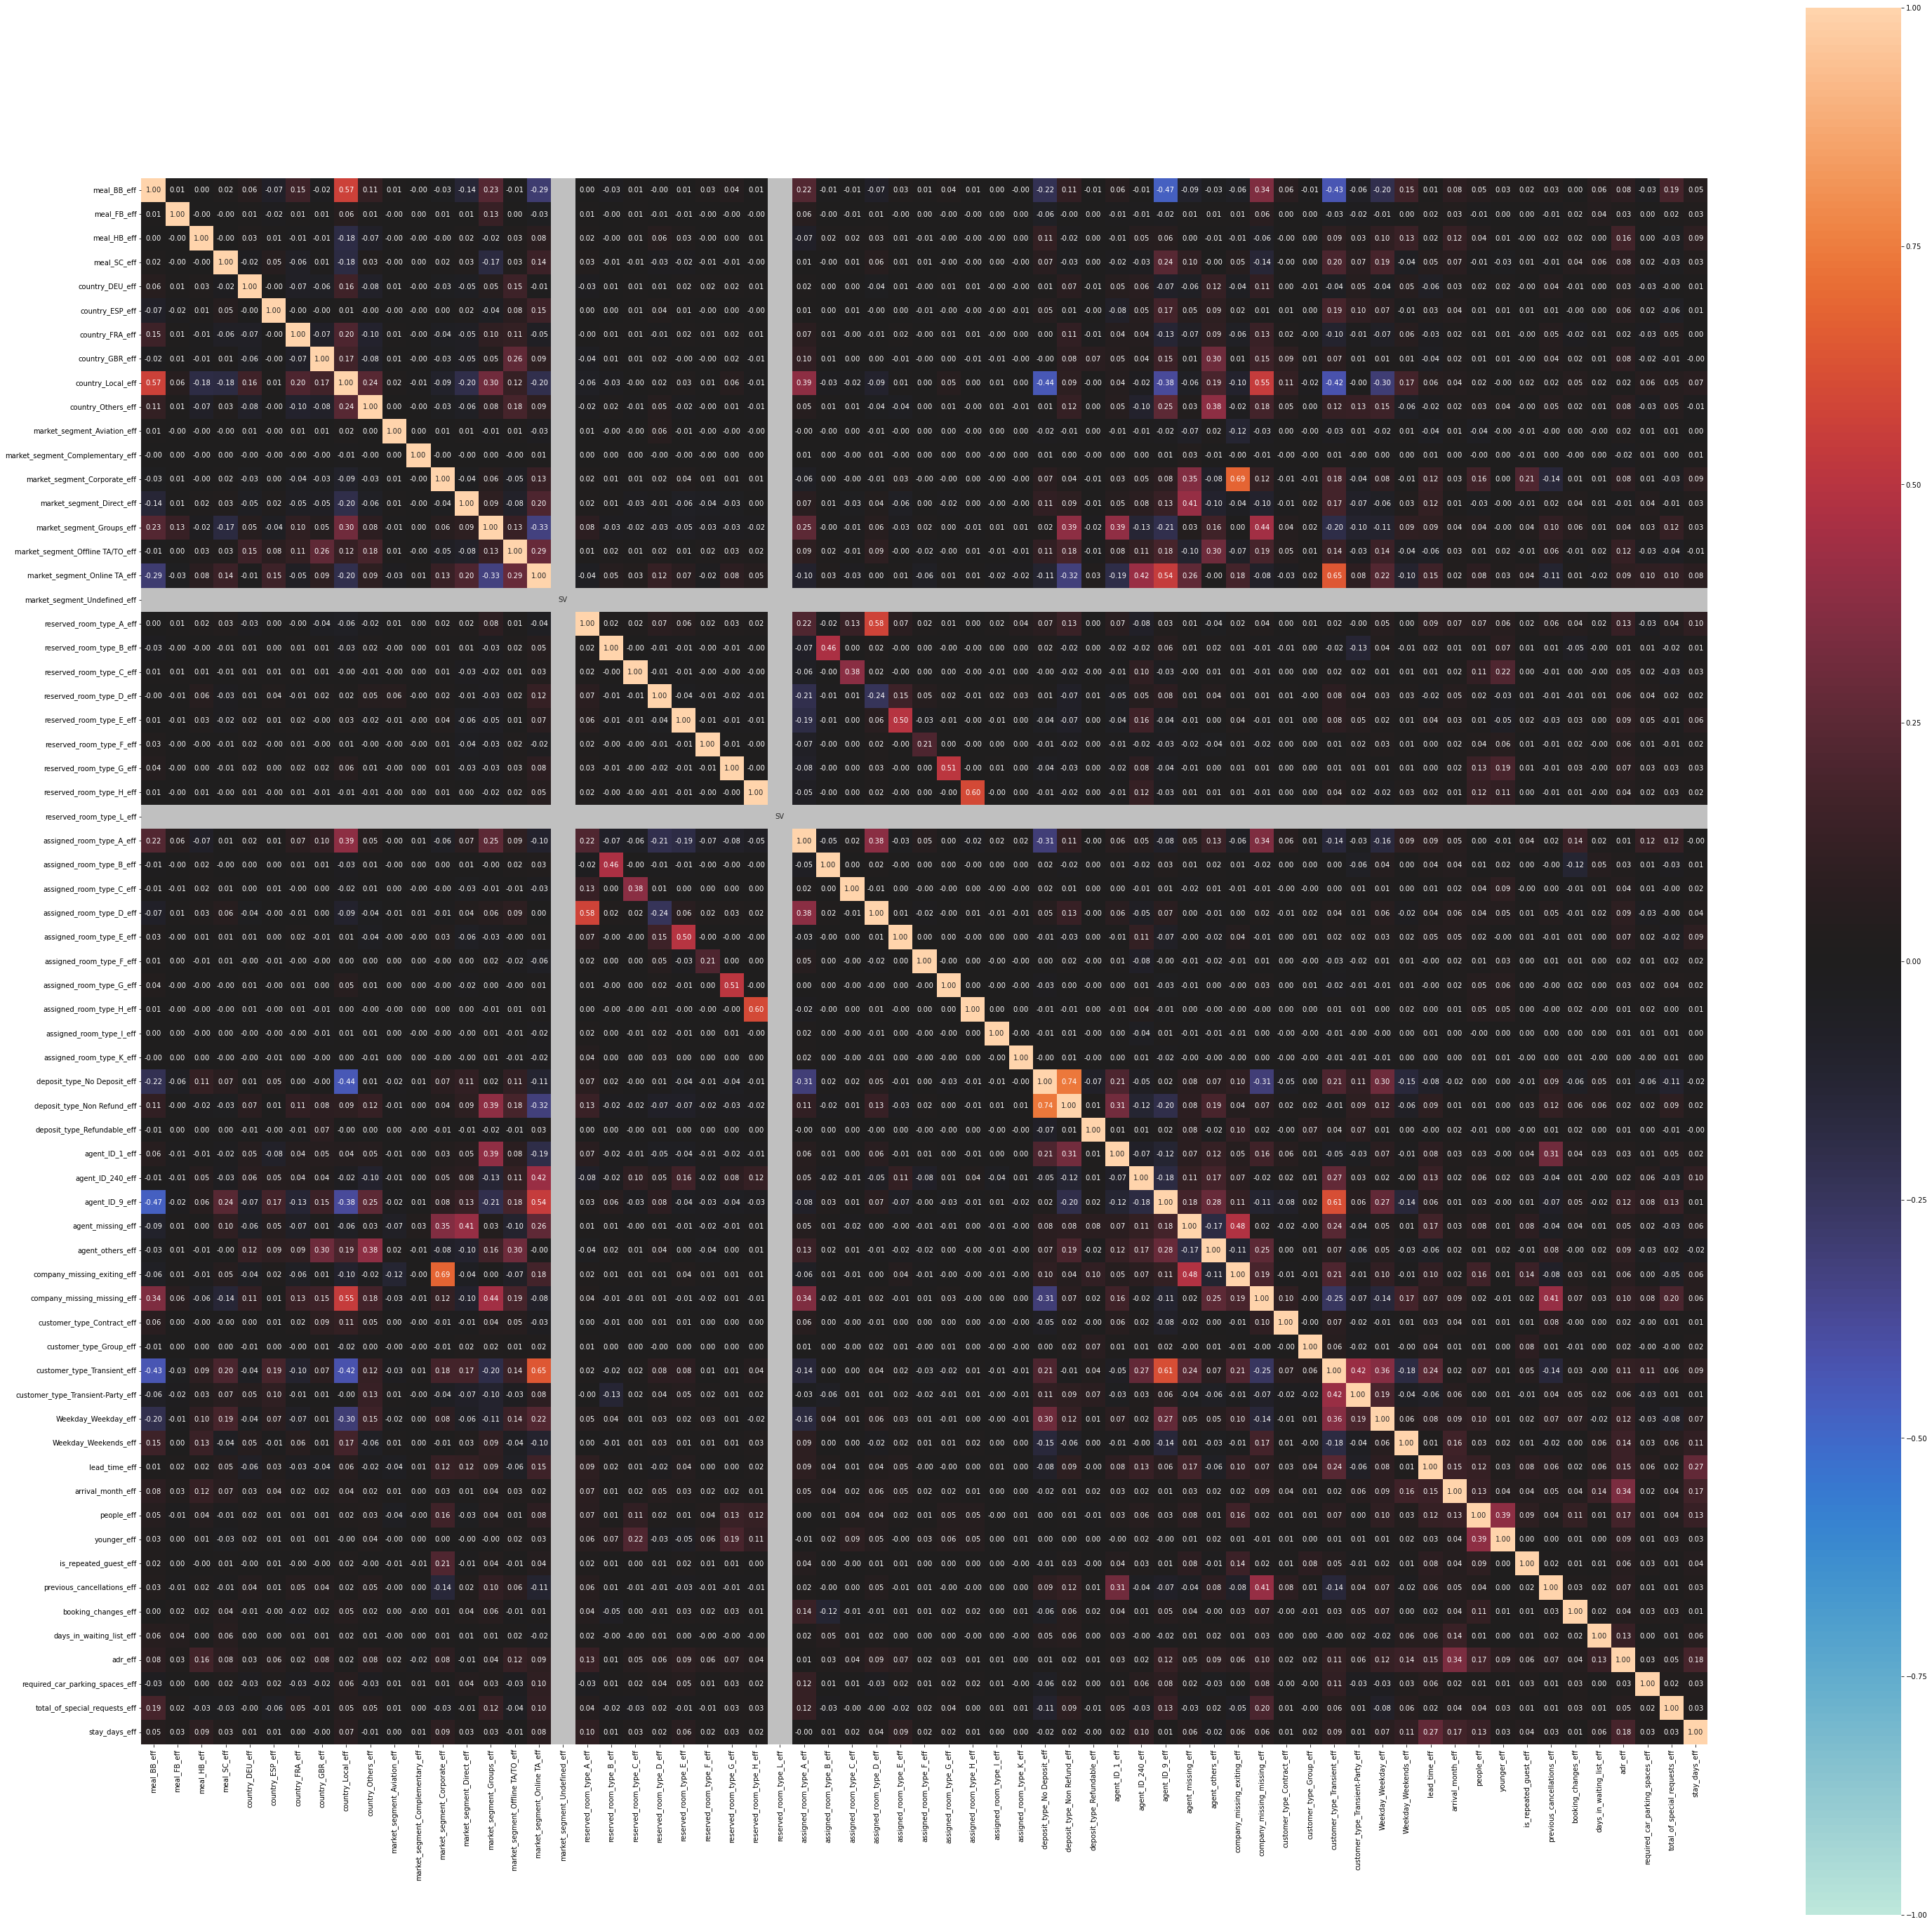

In [160]:
associations(df_feature.iloc[:,69:],figsize=(50,50),nom_nom_assoc='pearson')
plt.show()

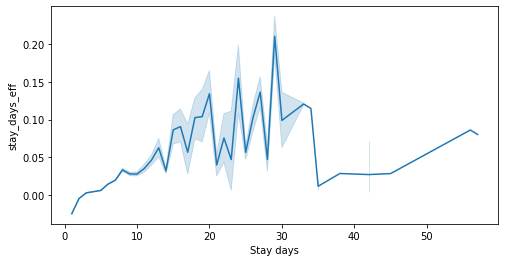

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(data = df_feature,x="stay_days",y="stay_days_eff")
plt.xlabel("Stay days")
plt.show()

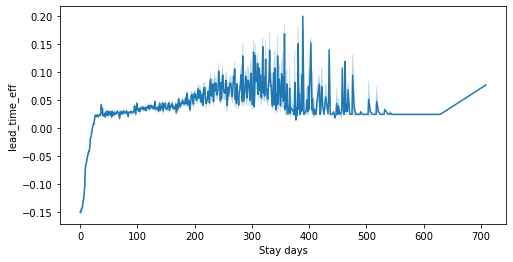

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(data = df_feature,x="lead_time",y="lead_time_eff")
plt.xlabel("Stay days")
plt.show()

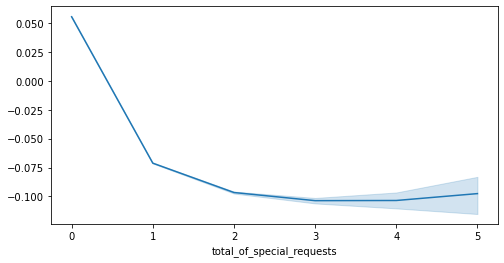

In [ ]:
""" plt.figure(figsize=(8,4))
sns.lineplot(X_train_array[:,67].flatten(),contribution[:,67,1].flatten())
plt.xlabel("total_of_special_requests")
plt.show() """

In [ ]:
X_train_array[0,:].shape

(69,)

In [ ]:
# Sum of the contributions depends on the proportion of our data!!!! 
""" plt.figure(figsize=(10,12))
sns.barplot(np.sum(contribution,axis=0)[:,1],feature_names)
plt.title("Contributions of features of the cases being canceled for all training data")
plt.show() """

' plt.figure(figsize=(10,12))\nsns.barplot(np.sum(contribution,axis=0)[:,1],feature_names)\nplt.title("Contributions of features of the cases being canceled for all training data")\nplt.show() '

In [ ]:
""" np.sum(contribution,axis=0) """

' np.sum(contribution,axis=0) '

In [ ]:
best_pipe.predict_proba(X_test.iloc[0:1])

array([[0.68830633, 0.31169367]])

`Remark`: We can see that the contributions of the features of the first booking in the train data are not totally consistent with the heatmap that visualizes the univariate relations with the response (Confirmed/Canceled), because these contributions consider the presence of other features. In other words, this plot is observation specific in terms of interpretation, that is, each feature may have different importances for different bookings, depending on how its features combine. For this booking, the `booking changes` contribute the most for it being confirmed, its `total_of_special_request` makes it more likely to be confirmed

## 4. Discussion & Conclusions


**1. Overview of the final model**

In this project, we investigated methods including Random Forest Classifier, Extra Trees Classifier, Cat Boost, Decision Tree Classifie, ANN and Logistic Regression. And finally choose to build the Random Forest algorithm and the tree based model, the reason is stated in next part.

Before implementing the model, we first deal with missing values and abnormal values, and also create some new columns. And then we create a pipeline that contains one-hot transformer and random forest classifier, and use randomized search to look for suitable parameters. The reason we don't use grid search is that randomised search is much faster. Our model with the best parameters achieves accuracy of 87.86%.


**2. Why do we prefer the tree based model and random forest algorithm?**

The tree structure takes account of the correlation naturally, while we have shown that the correlation in this case is so large that we cannot ignore it. In addition, the tree based model is robust to different scaling for numerical features. We also find that a pruned decision tree (with about 84% correct classification rate) performs better than logistic regreeesion(with about 80% correct classification rate). On the other hand, random forest algorithm can overcome the pontential problems of a single tree such as overfitting and poor generability. Therefore, we choose the tree based model and random forest algorithm as our main model and method for this report.

<b>3. Implication of the model </b>  

We choose the random forest algorithm to eliminate the overfitting problem to obtain better results. Overall, in this project, we build a random forest model with the aim of analyzing the reasons for room cancellations and discussing hotel revenue in terms of potential gains and losses for the hotel.
The accuracy of the model prediction is 87.86%, where country, deposit type, total of special requests, agent and lead_time have a greater impact on the prediction result. We found that:
- the more local (Portuguese) users, the higher the probability of cancellation.
- the deposit type of none refund have large probability of cancellation.
- the fewer requests for the order or the fewer changes to the order, the higher the possibility of cancellation.
- agent pays have large probability of cancellation
- the longer lead time, the higher the possibility of cancellation

<b>4. Recommendation</b> 

In response to economic feasibility, we can suggest the following to hotels that:
- implementing a slightly stricter cancel policy for local users.
- A more flexible reminder and refund strategy for orders booked more than 200 days, such as sending an email to remind users one month before check-in to prevent losses to hotels caused by cancellations near the end of the period.

As for other conclusions, we think it is more difficult to change in the market environment, for example, even though agents pay higher cancellation rates, we cannot eliminate agents as a sales channel in order to get good revenue. But we use these recommendations to develop more flexible refund and change policies for different groups combined with the market environment.